In [20]:
import pandas as pd
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt


In [3]:
# load LAGT - modify to fit your location!
LAGT = pd.read_json("/Users/vojtechkase/Projects/LAGT/data/large_files/LAGT_v3-0.json") # modify according to your own...

### extract sentences and count freqvencies

In [4]:
# extract all sentences from early christian texts
early_christian_sentences = [
    [t.lower() for t in sent]
    for work in LAGT[
        (LAGT['provenience'] == 'christian') & (LAGT['not_after'] <= 300)
        ]['lemmatized_sentences']
    for sent in work
]
len(early_christian_sentences)

154577

In [6]:
# extract sentences with the target term
target = "ἐχθρός"
target_sentences = [sent for sent in early_christian_sentences if target in sent]
len(target_sentences)

677

In [7]:
# filter the sentences from stop words
stop_words = {'μή', 'ἑαυτοῦ', 'ἄν', "ἀλλ'", 'ἀλλά', 'ἄλλος', 'ἀπό', 'ἄρα', 'αὐτός', "δ'", 'δέ', 'δή', 'διά', 'δαί', 'δαίς', 'ἔτι', 'ἐγώ', 'ἐκ', 'ἐμός', 'ἐν', 'ἐπί', 'εἰ', 'εἰμί', 'εἴμι', 'εἰς', 'γάρ', 'γε', 'γα', 'ἡ', 'ἤ', 'καί', 'κατά', 'μέν', 'μετά', 'μή', 'ὁ', 'ὅδε', 'ὅς', 'ὅστις', 'ὅτι', 'οὕτως', 'οὗτος', 'οὔτε', 'οὖν', 'οὐδείς', 'οἱ', 'οὐ', 'οὐδέ', 'οὐκ', 'περί', 'πρός', 'σύ', 'σύν', 'τά', 'τε', 'τήν', 'τῆς', 'τῇ', 'τι', 'τί', 'τις', 'τίς', 'τό', 'τοί', 'τοιοῦτος', 'τόν', 'τούς', 'τοῦ', 'τῶν', 'τῷ', 'ὑμός', 'ὑπέρ', 'ὑπό', 'ὡς', 'ὦ', 'ὥστε', 'ἐάν', 'παρά', 'σός'}
target_sentences = [[t for t in sent if t not in stop_words] for sent in target_sentences]

In [8]:
len(target_sentences)

677

In [9]:
# target sentences as a flat list of words
# (useful for counting frequencies, but not for co-occurrances ;-)
target_sentences_flat = [t for sent in target_sentences for t in sent]

In [10]:
top_n = 500
wordcounts = Counter(target_sentences_flat)


In [14]:
# generate a list of the most frequent terms to be used as our vocabulary 
most_occur = [word for word, count in wordcounts.most_common(top_n)]
most_occur[:10]

['ἐχθρός',
 'θεός',
 'γίγνομαι',
 'λέγω',
 'πᾶς',
 'φίλος',
 'ἀγαπάω',
 'χριστός',
 'θάνατος',
 'λόγος']

### Generate co-occurrance matrix

In [16]:
vectorizer = CountVectorizer(vocabulary=most_occur) # , token_pattern=r"(?u)\b\w+\b")
X = vectorizer.fit_transform([" ".join(sent) for sent in target_sentences])
X_dense = X.toarray()

# Create the co-occurrence matrix
co_occurrence_matrix = (X.T @ X).toarray()

# Replace diagonal with zeros (optional, if you don't want to count the word itself as its neighbor)
np.fill_diagonal(co_occurrence_matrix, 0)

# Display the co-occurrence matrix
print(co_occurrence_matrix)


[[  0 125  86 ...   2   2   2]
 [125   0  33 ...   2   2   0]
 [ 86  33   0 ...   0   0   0]
 ...
 [  2   2   0 ...   0   1   0]
 [  2   2   0 ...   1   0   0]
 [  2   0   0 ...   0   0   0]]


In [17]:
co_occurrence_df = pd.DataFrame(co_occurrence_matrix, index=most_occur, columns=most_occur)
co_occurrence_df

,ἐχθρός,θεός,γίγνομαι,λέγω,πᾶς,φίλος,ἀγαπάω,χριστός,θάνατος,λόγος,...,ἐπιτίθημι,μαρδοχαῖος,ἐσθήρ,ἀνοικοδομέω,αἴγυπτος,λανθάνω,μυστήριον,ἀπαλλάσσω,θέλημα,συντέλεια
ἐχθρός,0,125,86,60,59,62,50,56,52,41,...,2,2,2,2,4,2,3,2,2,2
θεός,125,0,33,18,23,13,4,12,6,10,...,1,0,0,1,2,1,1,2,2,0
γίγνομαι,86,33,0,10,8,13,13,12,7,4,...,1,0,0,0,0,0,0,0,0,0
λέγω,60,18,10,0,9,5,6,8,4,8,...,0,1,1,0,0,0,0,0,0,0
πᾶς,59,23,8,9,0,1,4,8,2,3,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
λανθάνω,2,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,1,1,0
μυστήριον,3,1,0,0,0,0,0,1,0,1,...,0,0,0,0,0,1,0,1,1,0
ἀπαλλάσσω,2,2,0,0,0,0,1,0,0,1,...,0,0,0,0,0,1,1,0,1,0
θέλημα,2,2,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,1,1,0,0


In [24]:
# create a networkx network object straight from our co-occurrance network
G = nx.from_pandas_adjacency(co_occurrence_df)
for i, row in co_occurrence_df.iterrows():
    for j, weight in row.items():
        if weight > 0:
            G[i][j]['weight'] = weight

#G.remove_edges_from(nx.selfloop_edges(G))

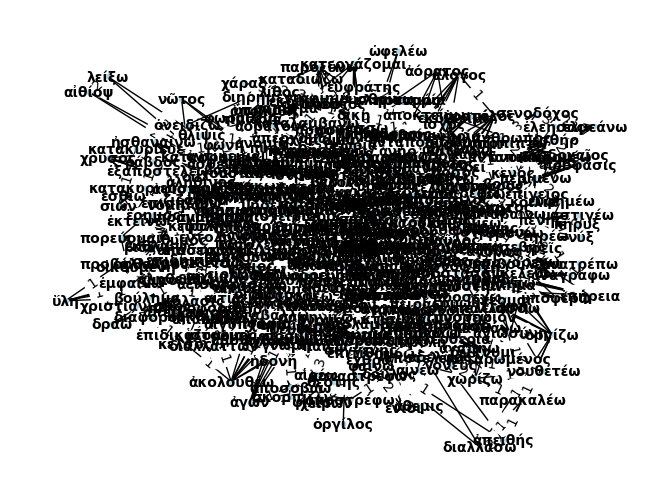

In [25]:
# test it with a simple plot...
pos = nx.spring_layout(G)
weights = nx.get_edge_attributes(G, 'weight')
nx.draw(G, pos, with_labels=True, node_size=10, node_color='lightblue', font_size=10, font_weight='bold')
nx.draw_networkx_edge_labels(G, pos, edge_labels=weights)
plt.show()

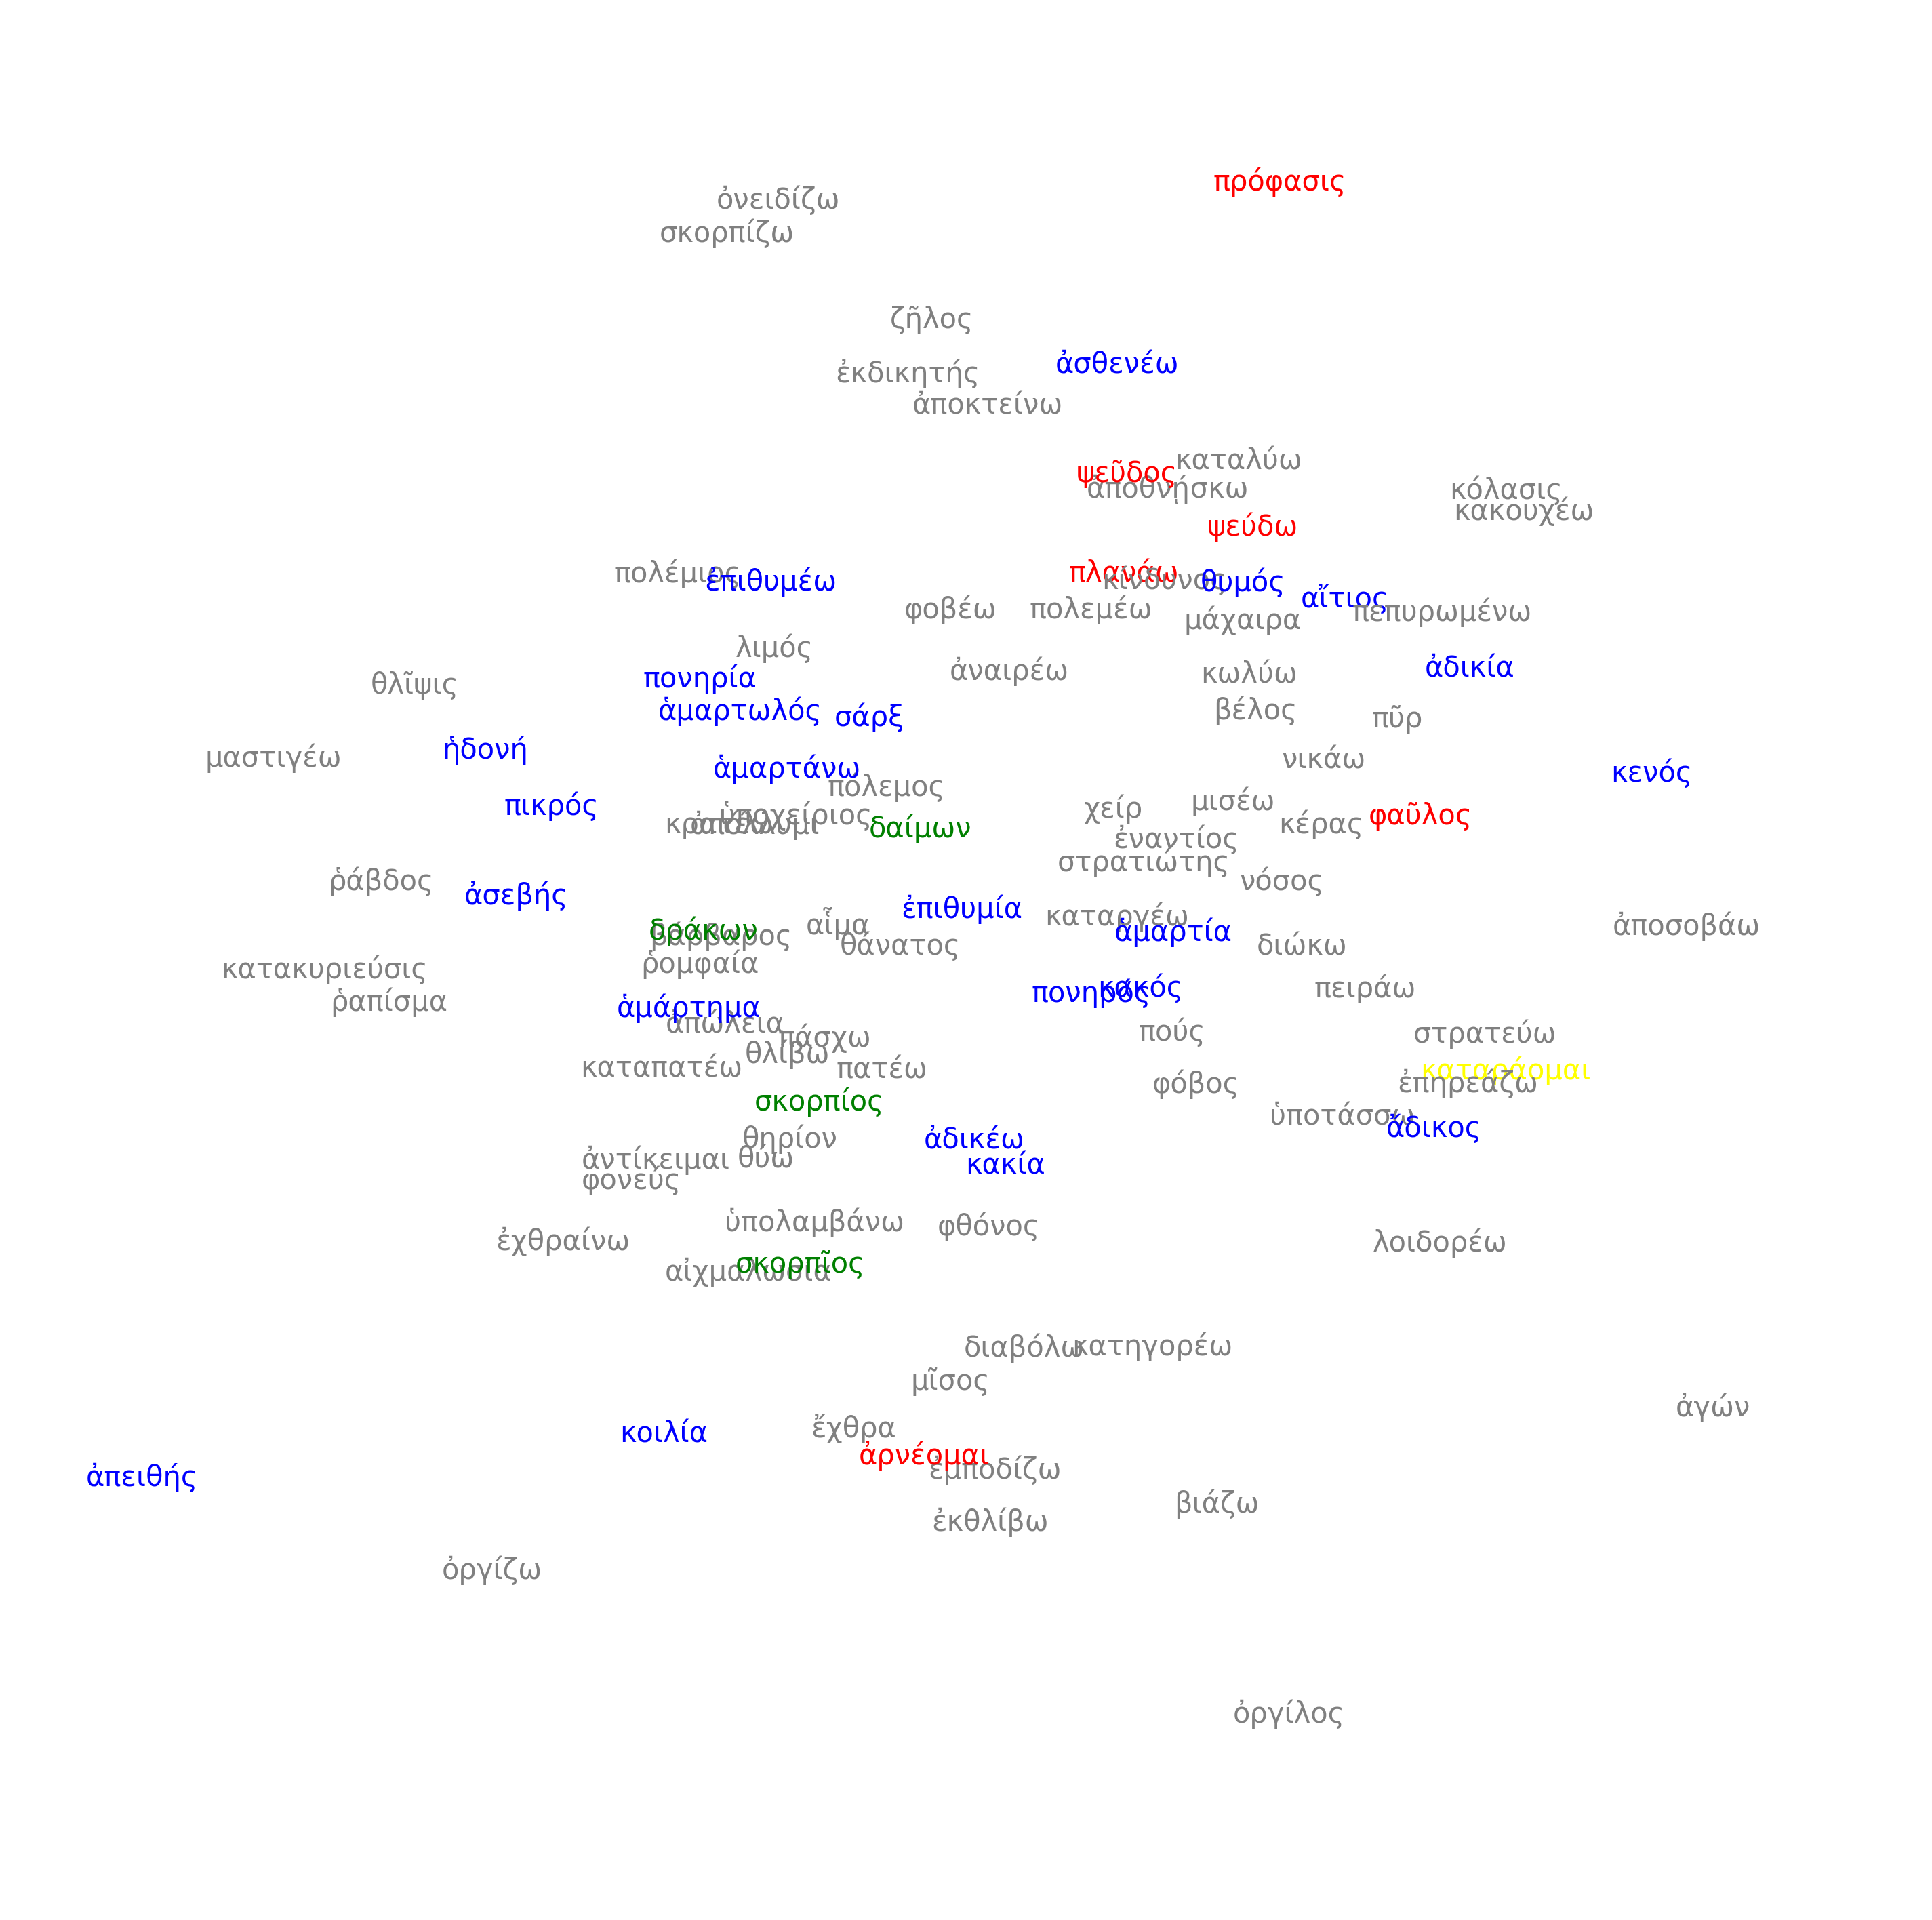

In [33]:
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.lines import Line2D

# Calculate positions using the spring layout
pos = nx.spring_layout(G, k=0.15, iterations=20, scale=2)

# Change these according to your categorization
group1 = ['καταράομαι', 'ἀνθρωποκτονοῦντος']
group2 = ['πλανάω', 'ψεῦδος', 'φαῦλος', 'ἐπιχαιρεκακία', 'ψεύδω', 'πρόφασις', 'ἀρνέομαι']
group3 = ['κακός', 'ἀδικέω', 'πονηρός', 'ἁμαρτία', 'σάρξ', 'αἴτιος', 'ἁμαρτωλός', 'ἐπιθυμία', 'ἁμαρτάνω', 'κακία',
          'ἀδικία', 'ἡδονή', 'ἀσεβής', 'κενός', 'θυμός', 'ἀσθενέω', 'πονηρία', 'ἁμάρτημα', 'ἐπιθυμέω', 'ἄδικος',
          'ἀπειθής', 'πικρός', 'κοιλία']
group4 = ['θάνατος', 'χείρ', 'πούς', 'καταργέω', 'μισέω', 'διώκω', 'πατέω', 'φόβος', 'μάχαιρα', 'πολεμέω', 'θλίβω',
          'βέλος', 'πάσχω', 'πόλεμος', 'ὑπολαμβάνω', 'νόσος', 'ἐναντίος', 'πειράω', 'φοβέω', 'αἰχμαλωσία', 'ὑποχείριος',
          'πῦρ', 'φθόνος', 'ἀπόλλυμι', 'ἀπώλεια', 'ἀποθνῄσκω', 'κρατέω', 'κωλύω', 'ἀναιρέω', 'νικάω', 'ἐκδικητής',
          'ὀνειδίζω', 'ὀργίλος', 'ῥομφαία', 'ὑποτάσσω', 'κατακυριεύσις', 'αἷμα', 'λιμός', 'λοιδορέω', 'καταπατέω',
          'ἀντίκειμαι', 'καταλύω', 'πεπυρωμένω', 'κέρας', 'ἐκθλίβω', 'ἐπηρεάζω', 'θηρίον', 'μῖσος', 'βάρβαρος',
          'πολέμιος', 'στρατιώτης', 'ῥάβδος', 'ζῆλος', 'κατηγορέω', 'ἐχθραίνω', 'κακουχέω', 'κόλασις', 'διαβόλω',
          'καταδουλόω', 'κίνδυνος', 'θύω', 'στρατεύω', 'κακολογέω', 'ἔχθρα', 'θλῖψις', 'βιάζω', 'φονεύς', 'σκορπίζω',
          'ῥαπίσμα', 'ὀργίζω', 'ἐμποδίζω', 'μαστιγέω', 'ἀποκτείνω', 'ἀποσοβάω', 'ἀγών']
group5 = ['σκορπίος', 'δαίμων', 'σκορπῖος', 'διαβολή' 'ὄφις', 'δράκων', 'σατανᾶς']
color_map = []

# Define color mapping
omitted_nodes = []
for node in G:
    if node in group1:
        color_map.append('yellow')
    elif node in group2:
        color_map.append('red')
    elif node in group3:
        color_map.append('blue')
    elif node in group4:
        color_map.append('grey')
    elif node in group5:
        color_map.append('green')
    else:
        color_map.append('white')
        omitted_nodes.append(node)

# Get x and y positions separately
x_vals, y_vals = zip(*pos.values())

# Create figure and axis objects
fig, ax = plt.subplots(figsize=(12, 12), dpi=300)

# Draw filtered weighted edges
filtered_edges = [(u, v, d) for u, v, d in G.edges(data=True) if u not in omitted_nodes and v not in omitted_nodes]
weights = [d['weight'] for _, _, d in filtered_edges]

#nx.draw_networkx_edges(G, pos, edgelist=filtered_edges, width=weights, alpha=0.5, ax=ax)

# Draw nodes
#nx.draw_networkx_nodes(G, pos, node_size=100, node_color=color_map, ax=ax)

# Draw each label with its corresponding color
for node, (x, y) in pos.items():
    if node not in omitted_nodes:
        nx.draw_networkx_labels(G, {node: (x, y)}, labels={node: node},
                                font_size=10,
                                #font_size=np.log2(wordcounts[node])*5,
                                font_family="sans-serif", verticalalignment='bottom',
                                font_color=color_map[list(G.nodes()).index(node)], ax=ax)

# Define legend elements
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='group1', markerfacecolor='yellow', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='group2', markerfacecolor='red', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='group3', markerfacecolor='blue', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='group4', markerfacecolor='grey', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='group5', markerfacecolor='green', markersize=10),
]

# Customize legend
#ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1, 1),
#           numpoints=1, frameon=True, shadow=True)

# Set the x and y limits to fit all values
ax.set_xlim(min(x_vals) - 0.1, max(x_vals) + 0.1)
ax.set_ylim(min(y_vals) - 0.1, max(y_vals) + 0.1)

# Hide axes
ax.axis("off")

# Show the plot
plt.show()

In [36]:
fig.savefig("../figures/network-without-edges_v1.png")

### Pasi's original code (for backup purposes)

In [2]:
#Cleaning up title names
korpus['title'].replace(['Fragmenta in Librum Primum Regnorum (In Catenis de Samuelis et\n                    Regnorum)'], 'Fragmenta in Librum Primum Regnorum (In Catenis de Samuelis et Regnorum)', inplace=True)
korpus['title'][700:720]

/var/folders/57/tg7c_g894t5c2z3swkqzds5h0000gn/T/ipykernel_63953/2621063896.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  korpus['title'].replace(['Fragmenta in Librum Primum Regnorum (In Catenis de Samuelis et\n                    Regnorum)'], 'Fragmenta in Librum Primum Regnorum (In Catenis de Samuelis et Regnorum)', inplace=True)


700                                     De Engastrimytho
701    Fragmenta in Librum Primum Regnorum (In Cateni...
702    Fragmentum In Librum Primum Regnorum (In Caten...
703                                    Homiliae In Lucam
704                      Fragmenta in Lucam (in catenis)
705                                           Philocalia
706                         In Jeremiam (Homiliae 12-20)
707     Commentarium In Evangelium Matthaei (Lib. 10-11)
708     Commentarium In Evangelium Matthaei (Lib. 12-17)
709                    Fragmenta in Psalmos 1-150 [Dub.]
710                                Epistula ad Africanum
711                                   Selecta in Genesim
712                                    Selecta in Exodum
713                                 Selecta in Leviticum
714                                   Selecta in Numeros
715                             Selecta in Deuteronomium
716                                Selecta in Jesum Nave
717                            

In [3]:
#Cleaning up title names
korpus['title'].replace(['Fragmentum In Librum Primum Regnorum (In Catenis de Cantico\n                    Canticorum)'], 'Fragmentum In Librum Primum Regnorum (In Catenis de Cantico Canticorum)', inplace=True)
korpus['title'][700:720]

/var/folders/57/tg7c_g894t5c2z3swkqzds5h0000gn/T/ipykernel_63953/3097074168.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  korpus['title'].replace(['Fragmentum In Librum Primum Regnorum (In Catenis de Cantico\n                    Canticorum)'], 'Fragmentum In Librum Primum Regnorum (In Catenis de Cantico Canticorum)', inplace=True)


700                                     De Engastrimytho
701    Fragmenta in Librum Primum Regnorum (In Cateni...
702    Fragmentum In Librum Primum Regnorum (In Caten...
703                                    Homiliae In Lucam
704                      Fragmenta in Lucam (in catenis)
705                                           Philocalia
706                         In Jeremiam (Homiliae 12-20)
707     Commentarium In Evangelium Matthaei (Lib. 10-11)
708     Commentarium In Evangelium Matthaei (Lib. 12-17)
709                    Fragmenta in Psalmos 1-150 [Dub.]
710                                Epistula ad Africanum
711                                   Selecta in Genesim
712                                    Selecta in Exodum
713                                 Selecta in Leviticum
714                                   Selecta in Numeros
715                             Selecta in Deuteronomium
716                                Selecta in Jesum Nave
717                            

In [4]:
#Selecting all Christian texts and their titles
all_christian = korpus[korpus['provenience'] == 'christian']
early_christian = all_christian[all_christian['not_after'] <= 300.0]

print(early_christian.title)
early_christian_titles = [works for works in early_christian.title]

0                         De Epistola Pinyti ad Dionysium
269                                          Acta Joannis
270                              Acta Joannis (recenscio)
372                                            Paedagogus
373                                   Eclogae propheticae
                              ...                        
1638                            Προτρεπτικὸς πρὸς Ἕλληνας
1639                                Stromata (Books I-VI)
1640                             τίς ὁ σωζόμενος πλούσιος
1641    ὁ Προτρεπτικὸς εἰς ὑπομονὴν ἢ πρὸς τοὺς νεωστὶ...
1688                                     Βαρνάβα ἐπιστολή
Name: title, Length: 116, dtype: object


In [5]:
#Selecting the lemmatized sentences
early_christian_lemma = early_christian['lemmatized_sentences']
early_christian_lemma = [texts for texts in early_christian_lemma]

In [7]:
#Extracting the following information: term and document frequency of ἐχθρός, number of words in the early Christian texts,
#list of all co-occuring words in the same sentence with ἐχθρός. 
word1 = 'ἐχθρός'
word2 = 'Ἐχθρός'
term_frequency = 0
document_frequency = 0
word_count = 0
sentence_list = []
frequency_titles = []
sentence_count = 0
clean_list = []

In [8]:
for n in range(0,(len(early_christian_titles))):
    work = early_christian_lemma[n] 
    for sentence in work: # for each sentence in the work represented as a list of sentences
        sentence_count += 1
        for word in sentence:
            word_count += 1
            if word1 in word:
                sentence_list += [sentence]
                clean_list += sentence
                term_frequency += 1
                document_frequency += 1
            elif word2 in word:
                sentence_list += sentence
                term_frequency += 1
                document_frequency += 1
            elif sentence_count == len(work):
                frequency_titles += [[early_christian_titles[n], document_frequency]]
                document_frequency = 0
                sentence_count = 0
                
sentence_list = [x.lower() for x in clean_list]
sentence_list = [word for word in clean_list if word != word1]
print(f'Total number of words in early Christian texts:{word_count}\nAll occurrences of {word2}: {term_frequency}\nThe frequency of {word2}: {(term_frequency)/(word_count)}\nList of co-occurring words (length: {len(sentence_list)}) with {word2} in the same sentence:\n',sentence_list)

Total number of words in early Christian texts:918539
All occurrences of Ἐχθρός: 714
The frequency of Ἐχθρός: 0.0007773213766644639
List of co-occurring words (length: 5440) with Ἐχθρός in the same sentence:
 ['ὀφθαλμός', 'πλήσσω', 'φυλάξησθε', 'πῦρ', 'σατή', 'ἔνεδρα', 'ἐκφεύξμαη', 'ζωή', 'αἰώνιος', 'οὐρανός', 'λαμβάνω', 'δείκνυμι', 'ἔδιον', 'γνῶσις', 'θεός', 'ἐθν', 'ἄμφω', 'ὀνειδίζω', 'φίλος', 'ἐπιγελάω', 'φίλος', 'εὐνοέω', 'παροξύνω', 'μάχαιρα', 'ἀντέχω', 'κρίμα', 'χείρ', 'αὐτός', 'ἀνταποδίδωμι', 'δίκη', 'μισέω', 'ἀνταποδίδωμι', 'γίγνομαι', 'ἀληθεύω', 'ἀγαπάω', 'κελεύω', 'καταράομαι', 'εὐλογέω', 'προσεύχομαι', 'ἐπηρεάζω', 'γνωστικός', 'μόνος', 'λέγω', 'Κρήτη', 'ἄγονος', 'εἰμί', 'θηρίον', 'ὀλέθριος', 'βίος', 'καθαρός', 'πᾶς', 'πονηρός', 'ἔργον', 'νόημα', 'λόγος', 'ἔχω', 'φθόνος', 'μῖσος', 'βλασφημία', 'πᾶς', 'διαβολή', 'εἰμί', 'θεός', 'θεά', 'ἔρχομαι', 'ἀρχαῖος', 'πενία', 'εὔφορος', 'πάμφορος', 'καρποτρόφος', 'χρυσός', 'ἀπέρχομαι', 'κεφαλή', 'χρυσός', 'χαλκός', 'λύπη', 'παρασκευαστικό

In [10]:

for works in range(0,(len(early_christian_titles))): # for index number of each work in the extent of early christian works
    for sentences in early_christian_lemma[works]: # for each sentence in the work represented as a list of sentences
        sentence_count += 1
        for words in sentences:
            word_count += 1
            if word1 in words:
                sentence_list += [sentences]
                clean_list += sentences
                term_frequency += 1
                document_frequency += 1
            elif word2 in words:
                sentence_list += sentences
                term_frequency += 1
                document_frequency += 1
            elif sentence_count == len(early_christian_lemma[works]):
                frequency_titles += [[early_christian_titles[works], document_frequency]]
                document_frequency = 0
                sentence_count = 0


sentence_list = [x.lower() for x in clean_list]
sentence_list = [words for words in clean_list if words != word1]
print(f'Total number of words in early Christian texts:{word_count}\nAll occurrences of {word2}: {term_frequency}\nThe frequency of {word2}: {(term_frequency)/(word_count)}\nList of co-occurring words (length: {len(sentence_list)}) with {word2} in the same sentence:\n',sentence_list)

Total number of words in early Christian texts:918539
All occurrences of Ἐχθρός: 714
The frequency of Ἐχθρός: 0.0007773213766644639
List of co-occurring words (length: 5440) with Ἐχθρός in the same sentence:
 ['ὀφθαλμός', 'πλήσσω', 'φυλάξησθε', 'πῦρ', 'σατή', 'ἔνεδρα', 'ἐκφεύξμαη', 'ζωή', 'αἰώνιος', 'οὐρανός', 'λαμβάνω', 'δείκνυμι', 'ἔδιον', 'γνῶσις', 'θεός', 'ἐθν', 'ἄμφω', 'ὀνειδίζω', 'φίλος', 'ἐπιγελάω', 'φίλος', 'εὐνοέω', 'παροξύνω', 'μάχαιρα', 'ἀντέχω', 'κρίμα', 'χείρ', 'αὐτός', 'ἀνταποδίδωμι', 'δίκη', 'μισέω', 'ἀνταποδίδωμι', 'γίγνομαι', 'ἀληθεύω', 'ἀγαπάω', 'κελεύω', 'καταράομαι', 'εὐλογέω', 'προσεύχομαι', 'ἐπηρεάζω', 'γνωστικός', 'μόνος', 'λέγω', 'Κρήτη', 'ἄγονος', 'εἰμί', 'θηρίον', 'ὀλέθριος', 'βίος', 'καθαρός', 'πᾶς', 'πονηρός', 'ἔργον', 'νόημα', 'λόγος', 'ἔχω', 'φθόνος', 'μῖσος', 'βλασφημία', 'πᾶς', 'διαβολή', 'εἰμί', 'θεός', 'θεά', 'ἔρχομαι', 'ἀρχαῖος', 'πενία', 'εὔφορος', 'πάμφορος', 'καρποτρόφος', 'χρυσός', 'ἀπέρχομαι', 'κεφαλή', 'χρυσός', 'χαλκός', 'λύπη', 'παρασκευαστικό

In [9]:
#Remove selected stop words 
remove_items = {'μή', 'ἑαυτοῦ', 'ἄν', "ἀλλ'", 'ἀλλά', 'ἄλλος', 'ἀπό', 'ἄρα', 'αὐτός', "δ'", 'δέ', 'δή', 'διά', 'δαί', 'δαίς', 'ἔτι', 'ἐγώ', 'ἐκ', 'ἐμός', 'ἐν', 'ἐπί', 'εἰ', 'εἰμί', 'εἴμι', 'εἰς', 'γάρ', 'γε', 'γα', 'ἡ', 'ἤ', 'καί', 'κατά', 'μέν', 'μετά', 'μή', 'ὁ', 'ὅδε', 'ὅς', 'ὅστις', 'ὅτι', 'οὕτως', 'οὗτος', 'οὔτε', 'οὖν', 'οὐδείς', 'οἱ', 'οὐ', 'οὐδέ', 'οὐκ', 'περί', 'πρός', 'σύ', 'σύν', 'τά', 'τε', 'τήν', 'τῆς', 'τῇ', 'τι', 'τί', 'τις', 'τίς', 'τό', 'τοί', 'τοιοῦτος', 'τόν', 'τούς', 'τοῦ', 'τῶν', 'τῷ', 'ὑμός', 'ὑπέρ', 'ὑπό', 'ὡς', 'ὦ', 'ὥστε', 'ἐάν', 'παρά', 'σός'}
filtered = [word for word in sentence_list if word not in remove_items]
print(f'The length of the filtered sentence_list is {len(filtered)}:{filtered}')

The length of the filtered sentence_list is 5226:['ὀφθαλμός', 'πλήσσω', 'φυλάξησθε', 'πῦρ', 'σατή', 'ἔνεδρα', 'ἐκφεύξμαη', 'ζωή', 'αἰώνιος', 'οὐρανός', 'λαμβάνω', 'δείκνυμι', 'ἔδιον', 'γνῶσις', 'θεός', 'ἐθν', 'ἄμφω', 'ὀνειδίζω', 'φίλος', 'ἐπιγελάω', 'φίλος', 'εὐνοέω', 'παροξύνω', 'μάχαιρα', 'ἀντέχω', 'κρίμα', 'χείρ', 'ἀνταποδίδωμι', 'δίκη', 'μισέω', 'ἀνταποδίδωμι', 'γίγνομαι', 'ἀληθεύω', 'ἀγαπάω', 'κελεύω', 'καταράομαι', 'εὐλογέω', 'προσεύχομαι', 'ἐπηρεάζω', 'γνωστικός', 'μόνος', 'λέγω', 'Κρήτη', 'ἄγονος', 'θηρίον', 'ὀλέθριος', 'βίος', 'καθαρός', 'πᾶς', 'πονηρός', 'ἔργον', 'νόημα', 'λόγος', 'ἔχω', 'φθόνος', 'μῖσος', 'βλασφημία', 'πᾶς', 'διαβολή', 'θεός', 'θεά', 'ἔρχομαι', 'ἀρχαῖος', 'πενία', 'εὔφορος', 'πάμφορος', 'καρποτρόφος', 'χρυσός', 'ἀπέρχομαι', 'κεφαλή', 'χρυσός', 'χαλκός', 'λύπη', 'παρασκευαστικός', 'φίλος', 'ἡδονή', 'παρασκευαστικώτατος', 'πολύς', 'φιλοῦνται', 'βλάβω', 'ἡδονή', 'κινδυνεύω', 'θεός', 'κόλαξ', 'θεῖος', 'Σωκράτης', 'ἐραστής', 'σοφία', 'πενία', 'κρείσσων', 'ἡδονή',

In [11]:
#Arrange frequency_titles and document frequencies into two lists
data_x = []
data_y = []

for text in frequency_titles:
        data_x.append(text[0])
        data_y.append(text[1])

#Remove all instances of zeros
x = []
y = []

for element in range(0,len(data_y)):
    if data_y[element] != 0:
        x.append(data_x[element])
        y.append(data_y[element])

print(x)
print(y)


['Acta Joannis', 'Paedagogus', 'Eclogae propheticae', 'Dialexeis', 'Apologia', 'Dialogus cum Tryphone', 'Supplication pro Christianis', 'De resurrectione', 'Epistula I ad Corinthios', 'Epistula II ad Corinthios', 'Ἐπιστολὴ Πέτρου πρὸς Ἰάκωβον', 'Διαμαρτυρία περὶ τῶν τοῦ βιβλίου λαμβανόντων', 'Ἐπιστολὴ Κλήμεντος πρὸς Ἰάκωβον\r\n', 'Ὁμίλαι', 'Clementina Epitome Prior Edita Correctior', 'Clementina Epitome Altera Nunc Primum Edita', 'Didache XII Apostolorum', 'Epistulae interpolatae et epistulae suppositiciae (recensio longior) [Sp.]', 'Ad Autolycum', 'Oratio ad Graecos', 'Μαρτύριον Περπετούας', 'Πράξεις τοῦ ἁγίου ἀποστόλου Θωμᾶ', 'Contra Celsum', 'Commentarii in Evangelium Joannis', 'Fragmenta In Evangelium Joannis (In Catenis)', 'Exhortatio ad martyrium', 'De oratione', 'In Jeremiam (Homiliae 1-11)', 'Fragmenta In Jeremiam (in Catenis)', 'Fragmenta In Lamentationes (In Catenis de Prophetis)', 'Fragmenta in Librum Primum Regnorum (In Catenis de Samuelis et Regnorum)', 'Homiliae In Lucam'

) missing from current font.os_venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


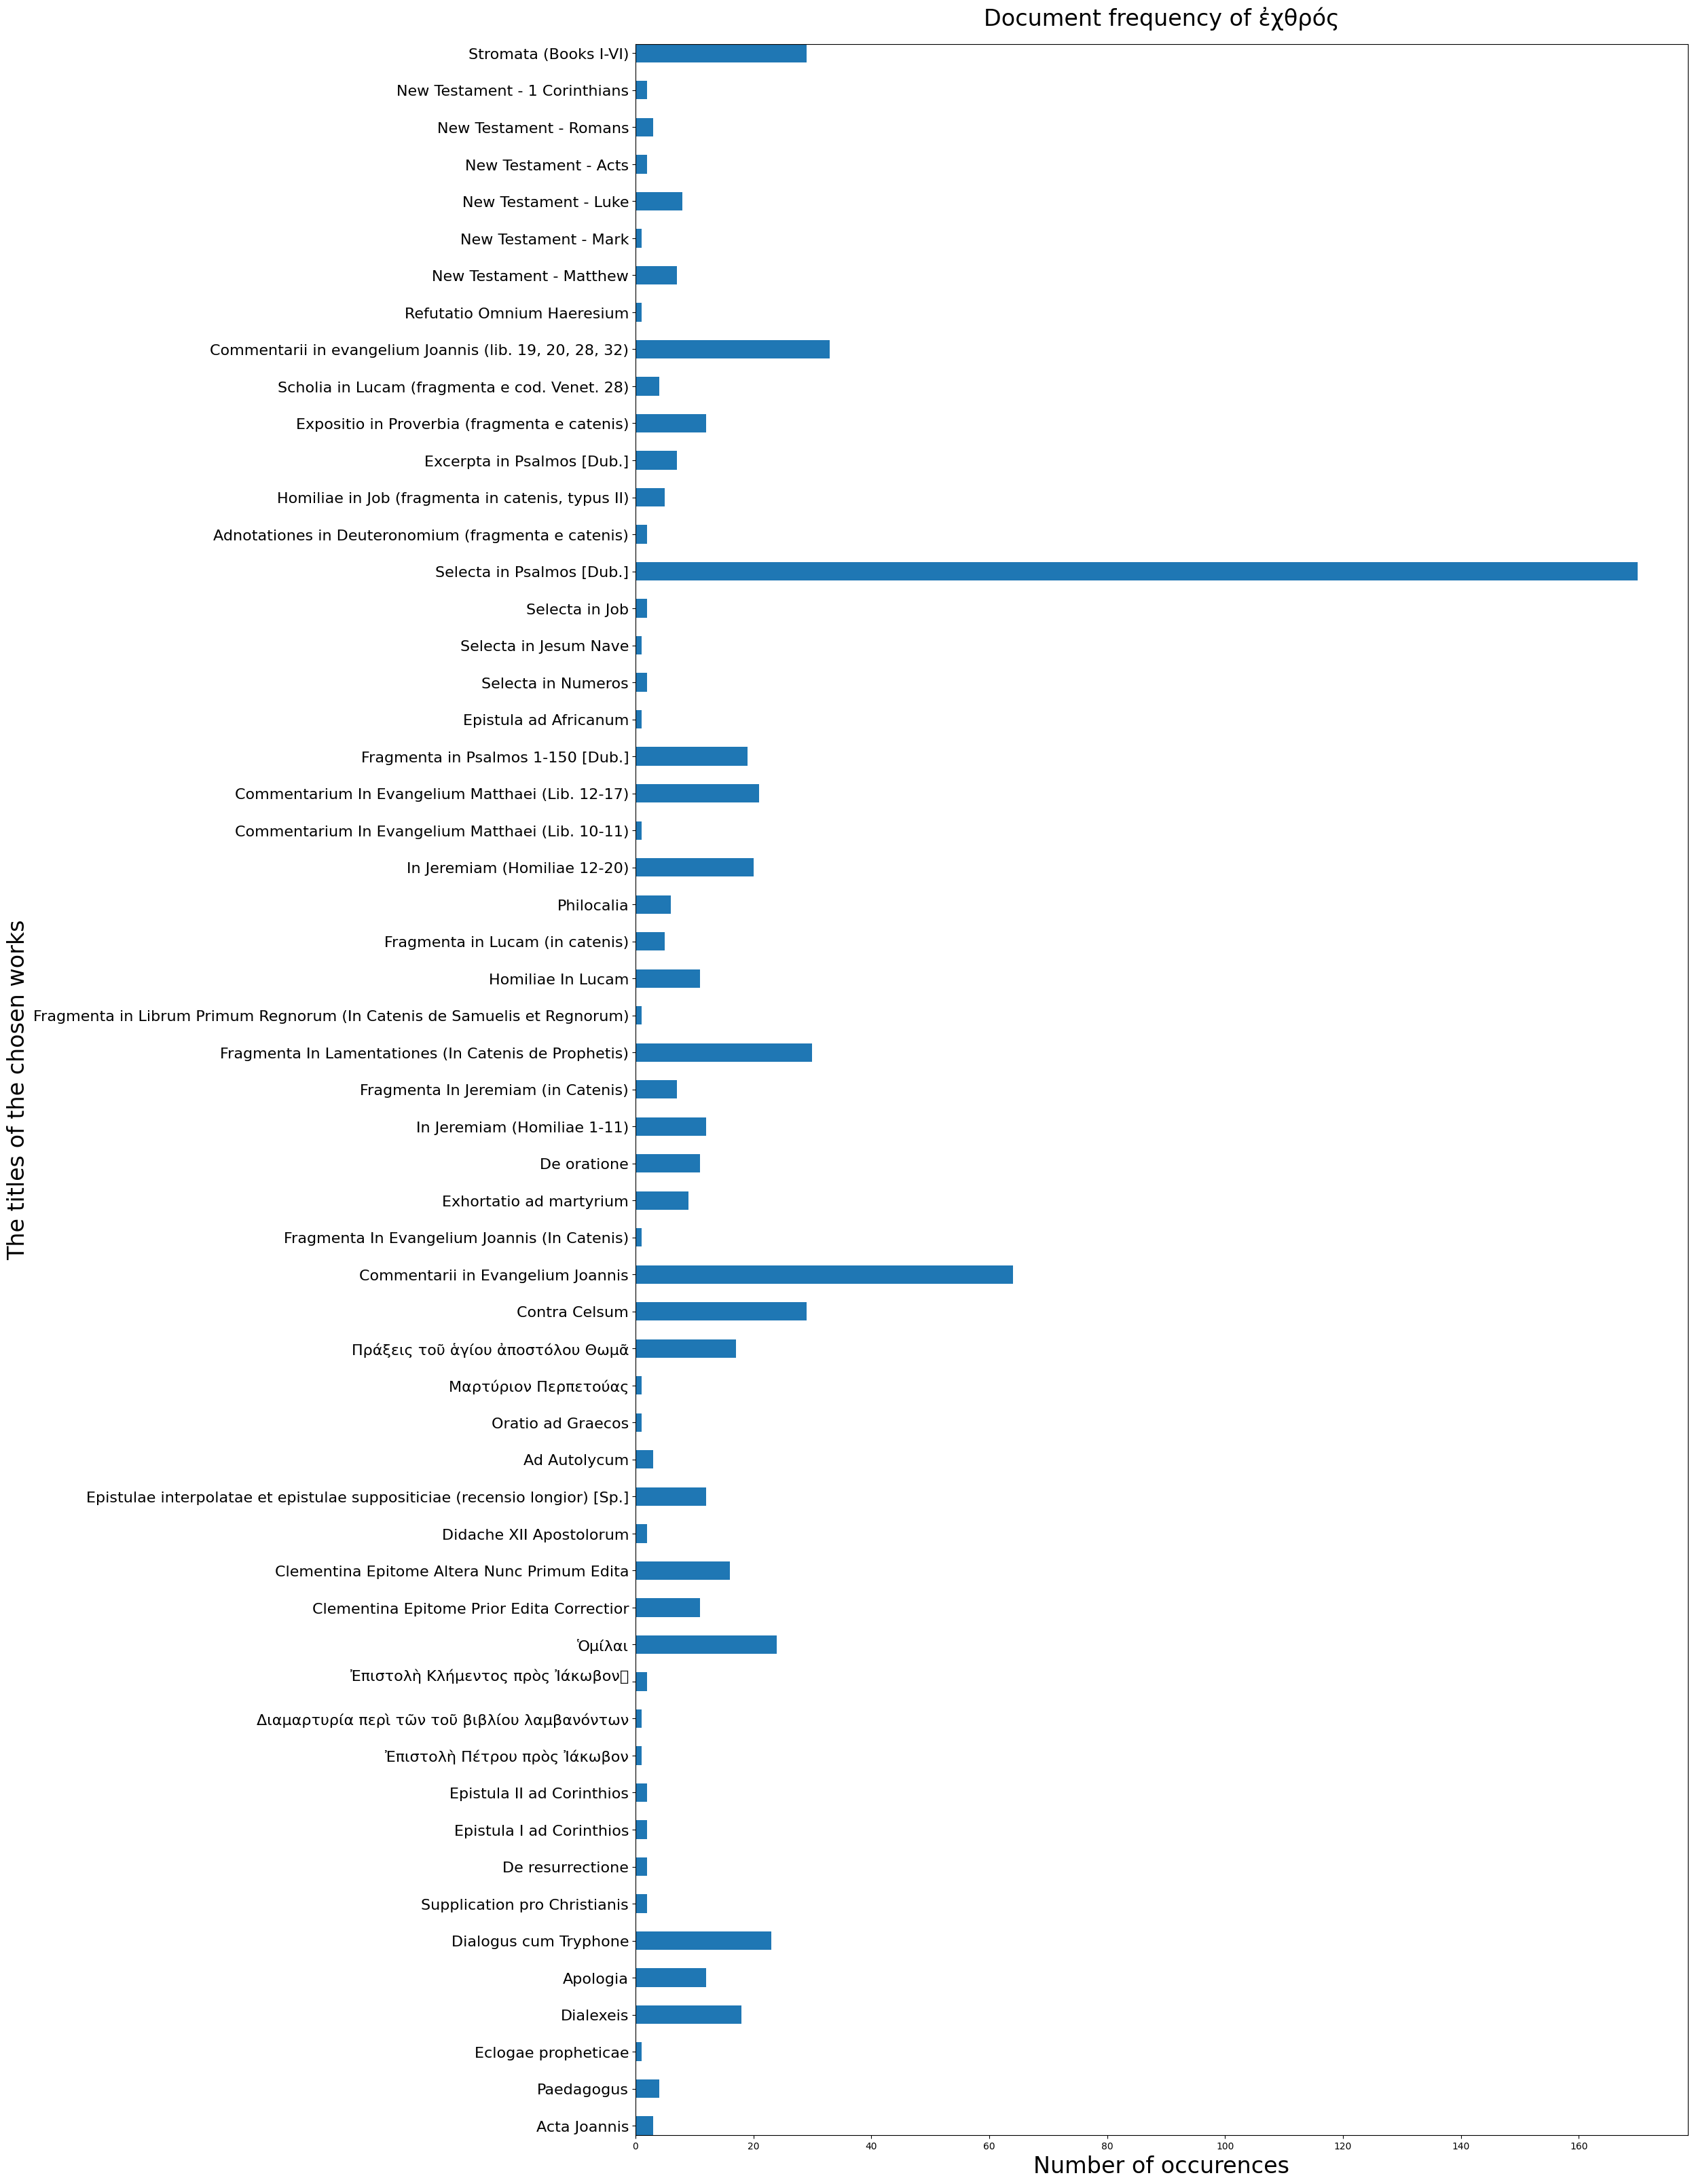

In [12]:
#Generating a bar chart (document frequency of ἐχθρός)
import matplotlib.pyplot as plt
import numpy as np

x = np.array(x)
y = np.array(y)

f, ax = plt.subplots(figsize=(20,40))
plt.barh(x, y, height = 0.5)
plt.margins(x=0.05,y=0)
ax.set_title('Document frequency of ἐχθρός', pad=20, fontsize=24)
plt.xlabel("Number of occurences", fontsize=24)
plt.ylabel("The titles of the chosen works", fontsize=24)
plt.tick_params(axis='y', which='major', labelsize=16)
plt.show()
#plt.savefig('/Users/Pasi/Desktop/bar_chart.png')

In [14]:
#Printing out a text for manual inspection
test_text = korpus[korpus['title'] == 'Demonstratio Evangelica']
test_text = test_text['lemmatized_sentences']
test_text.to_csv('test_text.txt', sep='\t', index=False)

In [15]:
#50 most common co-occurrences (with frequencies) based on sentences in early Christian texts
from collections import Counter
window_size = 500
Counter = Counter(filtered)

In [18]:
C

Counter({'θεός': 93,
         'γίγνομαι': 84,
         'φίλος': 61,
         'λέγω': 60,
         'πᾶς': 58,
         'Χριστός': 54,
         'θάνατος': 52,
         'ἀγαπάω': 43,
         'πατήρ': 43,
         'χείρ': 40,
         'λόγος': 40,
         'πούς': 40,
         'ψυχή': 39,
         'υἱός': 38,
         'ἄνθρωπος': 35,
         'ποιέω': 35,
         'προσεύχομαι': 31,
         'Θεός': 31,
         'δύναμις': 30,
         'καταργέω': 30,
         'μισέω': 29,
         'τίθημι': 29,
         'πολύς': 28,
         'ἔχω': 27,
         'οὐρανός': 26,
         'κύριος': 25,
         'Ἰησοῦς': 25,
         'λαμβάνω': 24,
         'ὑποπόδιον': 24,
         'ἔσχατος': 24,
         'δίδωμι': 23,
         'ἀλήθεια': 22,
         'δεξιός': 22,
         'ἐξουσία': 21,
         'ἀγαθός': 20,
         'φημί': 20,
         'διώκω': 19,
         'λαός': 18,
         'ὄφις': 17,
         'ἅγιος': 16,
         'πίπτω': 16,
         'κακός': 16,
         'βασιλεύς': 15,
         'οἶδα': 15,
  

In [20]:
term_frequency

714

In [21]:
most_occur = Counter.most_common(window_size)
most_occur1 = Counter.most_common(window_size)
frequency = [values[1] / term_frequency for values in most_occur] # does not make what it is supposed to do, as the term_frequency is caluculated wrongly...

In [23]:
most_occur = [most_occur[elem][0] for elem in range(0,(window_size))]
target_word = ['ἐχθρός'] * len(most_occur)
most_occur = list(zip(target_word, most_occur))
most_occur = [list(most_occur[element]) for element in range(0, len(most_occur))]
combine = list(zip(most_occur, frequency))
closest_words_to_target_word = str(combine).replace('[','').replace(']','')
closest_words_to_target_word = eval(closest_words_to_target_word)
closest_words_to_target_word

(('ἐχθρός', 'θεός', 0.13025210084033614),
 ('ἐχθρός', 'γίγνομαι', 0.11764705882352941),
 ('ἐχθρός', 'φίλος', 0.08543417366946779),
 ('ἐχθρός', 'λέγω', 0.08403361344537816),
 ('ἐχθρός', 'πᾶς', 0.08123249299719888),
 ('ἐχθρός', 'Χριστός', 0.07563025210084033),
 ('ἐχθρός', 'θάνατος', 0.07282913165266107),
 ('ἐχθρός', 'ἀγαπάω', 0.06022408963585434),
 ('ἐχθρός', 'πατήρ', 0.06022408963585434),
 ('ἐχθρός', 'χείρ', 0.056022408963585436),
 ('ἐχθρός', 'λόγος', 0.056022408963585436),
 ('ἐχθρός', 'πούς', 0.056022408963585436),
 ('ἐχθρός', 'ψυχή', 0.0546218487394958),
 ('ἐχθρός', 'υἱός', 0.05322128851540616),
 ('ἐχθρός', 'ἄνθρωπος', 0.049019607843137254),
 ('ἐχθρός', 'ποιέω', 0.049019607843137254),
 ('ἐχθρός', 'προσεύχομαι', 0.04341736694677871),
 ('ἐχθρός', 'Θεός', 0.04341736694677871),
 ('ἐχθρός', 'δύναμις', 0.04201680672268908),
 ('ἐχθρός', 'καταργέω', 0.04201680672268908),
 ('ἐχθρός', 'μισέω', 0.04061624649859944),
 ('ἐχθρός', 'τίθημι', 0.04061624649859944),
 ('ἐχθρός', 'πολύς', 0.0392156862745

In [24]:
#Run this cell only once!
most_occur1 = [most_occur1[elem][0] for elem in range(0,(window_size))]

In [26]:
#Search for all the closest neighbours between closest words of ἐχθρός

from collections import Counter
import re

result1 = []
result2 = []
position = 0
result3 = []
result4 = []

def most_frequent(result_all):
    occurence_count = Counter(result_all)
    most_freq = occurence_count.most_common(1)
    return most_freq

def most_frequent2(result_all):
    occurence_count = Counter(result_all)
    most_freq = occurence_count.most_common(2)[1]
    return most_freq

for element in range(0,(len(most_occur1))):
    for words in filtered:
        position += 1
        if words == most_occur1[element]:
            result1 += filtered[position-2:position-1]
            result2 += filtered[position:position+1]
        elif position == len(filtered):
            position = 0
            result_all = result1 + result2
            result = most_frequent(result_all)
            most_freq1 = result[0][0]
            if most_freq1 == most_occur1[element] or most_freq1 not in most_occur1:
                result_2 = most_frequent2(result_all)
                most_freq1 = result_2[0]
                most_freq2 = result_2[1]
                most_freq2 = (most_freq2/len(result_all))/2
                result4 += most_occur1[element],most_freq1,most_freq2
                result3.append(result4)
                result4 = []
                result1 = []
                result2 = []
            else: 
                result = most_frequent(result_all)
                most_freq1 = result[0][0]
                most_freq2 = result[0][1]
                most_freq2 = (most_freq2/len(result_all))/2
                result4 += most_occur1[element],most_freq1,most_freq2
                result3.append(result4)
                result4 = []
                result1 = []
                result2 = []

closest_neighbours = str(result3).replace('[','(').replace(']',')')
closest_neighbours = eval(closest_neighbours)
closest_neighbours

(('θεός', 'υἱός', 0.01881720430107527),
 ('γίγνομαι', 'υἱός', 0.044642857142857144),
 ('φίλος', 'αἴτιος', 0.04918032786885246),
 ('λέγω', 'γίγνομαι', 0.0125),
 ('πᾶς', 'δύναμις', 0.03017241379310345),
 ('Χριστός', 'πάσχω', 0.013888888888888888),
 ('θάνατος', 'καταργέω', 0.09615384615384616),
 ('ἀγαπάω', 'προσεύχομαι', 0.05813953488372093),
 ('πατήρ', 'οὐρανός', 0.08139534883720931),
 ('χείρ', 'νῶτον', 0.0375),
 ('λόγος', 'θεῖος', 0.01875),
 ('πούς', 'ὑποπόδιον', 0.1375),
 ('ψυχή', 'χείρ', 0.03205128205128205),
 ('υἱός', 'γίγνομαι', 0.09868421052631579),
 ('ἄνθρωπος', 'φίλος', 0.03571428571428571),
 ('ποιέω', 'μισέω', 0.02857142857142857),
 ('προσεύχομαι', 'διώκω', 0.13709677419354838),
 ('Θεός', 'χείρ', 0.03225806451612903),
 ('δύναμις', 'πᾶς', 0.058333333333333334),
 ('καταργέω', 'θάνατος', 0.16666666666666666),
 ('μισέω', 'ἀγαπάω', 0.05172413793103448),
 ('τίθημι', 'ὑποπόδιον', 0.15517241379310345),
 ('πολύς', 'Χριστός', 0.017857142857142856),
 ('ἔχω', 'χώρα', 0.027777777777777776),


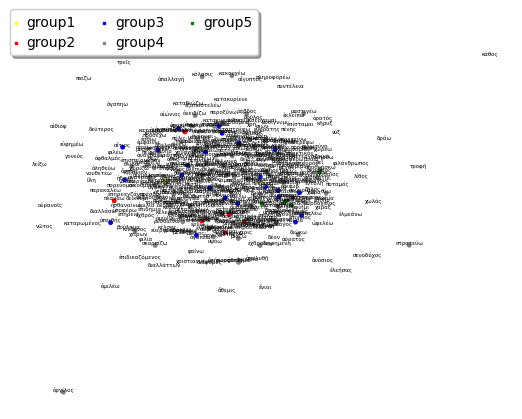

<Figure size 40000x40000 with 0 Axes>

In [73]:
pos = nx.kamada_kawai_layout(G) # , k=0.15, iterations=20, scale=2)
#pos = nx.spring_layout(G, k=0.15, iterations=20, scale=2)



#Change these according to your categorization
group1 = ['καταράομαι', 'ἀνθρωποκτονοῦντος']
group2 = ['πλανάω', 'ψεῦδος', 'φαῦλος', 'ἐπιχαιρεκακία', 'ψεύδω', 'πρόφασις', 'ἀρνέομαι']
group3 = ['κακός', 'ἀδικέω', 'πονηρός', 'ἁμαρτία', 'σάρξ', 'αἴτιος', 'ἁμαρτωλός', 'ἐπιθυμία', 'ἁμαρτάνω', 'κακία', 'ἀδικία', 'ἡδονή', 'ἀσεβής', 'κενός', 'θυμός', 'ἀσθενέω', 'πονηρία', 'ἁμάρτημα', 'ἐπιθυμέω', 'ἄδικος', 'ἀπειθής', 'πικρός', 'κοιλία']
group4 = ['θάνατος', 'χείρ', 'πούς', 'καταργέω', 'μισέω', 'διώκω', 'πατέω', 'φόβος', 'μάχαιρα', 'πολεμέω', 'θλίβω', 'βέλος', 'πάσχω', 'πόλεμος', 'ὑπολαμβάνω', 'νόσος', 'ἐναντίος', 'πειράω', 'φοβέω', 'αἰχμαλωσία', 'ὑποχείριος', 'πῦρ', 'φθόνος', 'ἀπόλλυμι', 'ἀπώλεια', 'ἀποθνῄσκω', 'κρατέω', 'κωλύω', 'ἀναιρέω', 'νικάω', 'ἐκδικητής', 'ὀνειδίζω', 'ὀργίλος', 'ῥομφαία', 'ὑποτάσσω', 'κατακυριεύσις', 'αἷμα', 'λιμός', 'λοιδορέω', 'καταπατέω', 'ἀντίκειμαι', 'καταλύω', 'πεπυρωμένω', 'κέρας', 'ἐκθλίβω', 'ἐπηρεάζω', 'θηρίον', 'μῖσος', 'βάρβαρος', 'πολέμιος', 'στρατιώτης', 'ῥάβδος', 'ζῆλος', 'κατηγορέω', 'ἐχθραίνω', 'κακουχέω', 'κόλασις', 'διαβόλω', 'καταδουλόω', 'κίνδυνος', 'θύω', 'στρατεύω', 'κακολογέω', 'ἔχθρα', 'θλῖψις', 'βιάζω', 'φονεύς', 'σκορπίζω', 'ῥαπίσμα', 'ὀργίζω', 'ἐμποδίζω', 'μαστιγέω', 'ἀποκτείνω', 'ἀποσοβάω', 'ἀγών']
group5 = ['σκορπίος', 'δαίμων', 'σκορπῖος', 'διαβολή' 'ὄφις', 'δράκων', 'σατανᾶς']
color_map = []

for node in G:
    if node in group1:
        color_map.append('yellow')
    elif node in group2:
        color_map.append('red')
    elif node in group3:
        color_map.append('blue')
    elif node in group4:
        color_map.append('grey')
    elif node in group5:
        color_map.append('green')
    #etc. 
    #add here more groups if needed
    else: 
        color_map.append('white')

nx.draw_networkx_nodes(G, pos, node_size=6, node_color=color_map)
nx.draw_networkx_labels(G, pos, font_size=4, font_family="sans-serif", verticalalignment='bottom')

#These are the legends seen in the graph, add new legends according the the gategorization
legend_elements = [
    Line2D([0], [0], marker='s', color='yellow', label='group1', markersize=2),
    Line2D([0], [0], marker='s', color='red', label='group2', markersize=2),
    Line2D([0], [0], marker='s', color='blue', label='group3', markersize=2),
    Line2D([0], [0], marker='s', color='grey', label='group4', markersize=2),
    Line2D([0], [0], marker='s', color='green', label='group5', markersize=2)
    #etc.
]

plt.rcParams['legend.handlelength'] = 0
plt.rcParams['legend.handleheight'] = 0

plt.legend(handles=legend_elements, loc='best', bbox_to_anchor=(0.5, 1.1),
          ncol=3, fancybox=True, shadow=True)

fig = plt.gcf()
plt.axis("off")
plt.figure(3,figsize=(400,400)) 
plt.show()

In [20]:
#Save the graph to your computer
fig.savefig("/Users/ninak/Desktop/grap2.jpeg",dpi=1000)